# 3. Clustering

In [1]:
# DA TOGLIERE / INTEGRARE

# Run this code to make Jupyter print every
# printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import *
import sklearn
from sklearn.model_selection import GridSearchCV #split the data into testing and test
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import VarianceThreshold


# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, classification_report
from sklearn.pipeline import Pipeline

#classification
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier 

In [2]:

# Libraries specific for clustering -> ALCUNE COSE POTREBBERO ESSERE DA TOGLIERE
import matplotlib.colors as mcolors
import random
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

The aim of our analysis is to divide customers into two groups:
- The ones that purchased something ('Revenue'== TRUE)
- The ones that exit the websites without purchasing ('Revenue'==FALSE)

The analysis has been performed using the test set because clustering doesn't have a train phase and in the end we will compare the performances of the best clustering algorithm with the ones of the best classification algorithm (previously tested on this test set). Moreover, classification algorithms are built using the training set, so it would be uneven comparing the performances of clustering and classification algorithm using the training set

In [3]:
# DA SISTEMARE CON L'ALTRO
test_set = pd.read_csv("NOTEBOOK/test_set_complete.csv")

test_set['Revenue'] = test_set['Revenue'].astype(int)

categorical_features = ['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'OperatingSystems_5', 'OperatingSystems_6',
       'OperatingSystems_7', 'OperatingSystems_8', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8',
       'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',
       'TrafficType_17', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20',
       'VisitorType_New_Visitor', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True']


In [4]:
X_test_full = test_set.drop(columns=['Revenue'])
y_test = test_set['Revenue']

## Data preprocessing

Since some clustering algorithms relies on distance metrics, we need data to have the same scale. For this reason, we standardize numeric features.

In [5]:
# QUESTO VA TENUTO, DIVERSO DALL'ALTRO VISTO CHE USIAMO TEST

# Assuming you have your feature data X
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 
                        'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_6', 'OperatingSystems_8', 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5',
                        'Region_6', 'Region_7', 'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_2', 
                        'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 
                        'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_13', 
                        'TrafficType_15', 'TrafficType_19', 'TrafficType_20', 'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True']
scaler = StandardScaler()
test_scaled = pd.DataFrame(scaler.fit_transform(X_test_full[numeric_features]))
test_scaled.columns = X_test_full[numeric_features].columns
X_test_scaled = pd.concat([test_scaled,X_test_full[categorical_features]],axis=1)

After standardization, we perform variance selection to remove features with a very low variance, as they are not so informative.

In [6]:
# giustamente qui troviamo un numero diverso di features visto che usiamo un altro dataset, le categoriche comunque ci sono tutte

threshold = 0.0075  # Soglia di varianza desiderata
variance_selector = VarianceThreshold(threshold=threshold)


X_test_scaled = X_test_scaled.loc[:, variance_selector.fit(X_test_scaled).get_support()]
columns_remaining = X_test_scaled.columns.tolist()

print(X_test_scaled.columns.tolist())
len(columns_remaining)

['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_8', 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_8', 'Browser_10', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_8', 'TrafficType_10', 'TrafficType_11', 'TrafficType_13', 'TrafficType_20', 'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True']


57

## Setting the constant parameters

In [7]:
n_clusters = 2
element_distance_metric = 'euclidean'
linkage = 'ward'

## Functions to evaluate clustering performances

### External Indexes

In [8]:
def get_count_nk(cluster_labels,k):
    return np.count_nonzero(cluster_labels == k)

def get_count_nj(class_labels,j):
    return np.count_nonzero(class_labels == j)

def get_count_nkj(cluster_labels,class_labels,k,j):
    return len(np.intersect1d(np.where(cluster_labels == k)[0], np.where(class_labels == j)[0]))

def get_precision(cluster_labels, class_labels, k, j):
    return get_count_nkj(cluster_labels,class_labels,k,j)/get_count_nk(cluster_labels,k)

def get_recall(cluster_labels, class_labels, k, j):
    return get_count_nkj(cluster_labels,class_labels,k,j)/get_count_nj(class_labels,j)

## da rivedere
def get_cluster_purity(cluster_labels,class_labels,k):
    precisions = []
    labels_in_cluster_k = np.unique(cluster_labels)
    for label in labels_in_cluster_k:
        precisions.append(get_precision(cluster_labels,class_labels,k,label))
    return max(precisions)

## da rivedere
def get_total_purity(cluster_labels,class_labels):
    purities = []
    labels_in_cluster_k = np.unique(cluster_labels)

    for cluster in labels_in_cluster_k:
        purities.append(get_cluster_purity(cluster_labels,class_labels,cluster)*(get_count_nk(cluster_labels,cluster)/len(cluster_labels)))
    return sum(purities)

def get_accuracy(cluster_labels,class_labels):
    return sum(cluster_labels == class_labels)/len(class_labels)

In [9]:
# returns all the external indexes
def get_cluster_metrics(cluster_labels,class_labels,model_name):
    
    accuracy = get_accuracy(cluster_labels,class_labels)
    
    cluster_label_unique = np.sort(np.unique(cluster_labels))
    class_label_unique = np.sort(np.unique(class_labels))
    
    precisions = []
    recalls = []
    
    purities = []
    
    for k in cluster_label_unique:
        for j in class_label_unique:
            precisions.append(get_precision(cluster_labels,class_labels,k,j))
        purities.append(get_cluster_purity(cluster_labels,class_labels,k))
        
    for j in class_label_unique:
        for k in cluster_label_unique:
            recalls.append(get_recall(cluster_labels,class_labels,k,j))
    
    tot_purity = get_total_purity(cluster_labels,class_labels)
    
    jaccard = sklearn.metrics.jaccard_score(class_labels, cluster_labels)
    
    data_gen = {
        'Accuracy':[accuracy],
        'purity cluster 0':[purities[0]],
        'purity cluster 1':[purities[1]],
        'tot_purity':[tot_purity],
        'jaccard':[jaccard],
    }
    data_precision = {
        'precision cluster0-class0':[precisions[0]],
        'precision cluster0-class1':[precisions[1]],
        'precision cluster1-class0':[precisions[2]],
        'precision cluster1-class1':[precisions[3]],
    }
    data_recall = {
        'recall class0-cluster0':[recalls[0]],
        'recall class0-cluster1':[recalls[1]],
        'recall class1-cluster0':[recalls[2]],
        'recall class1-cluster1':[recalls[3]],
    }
    data_gen = pd.DataFrame(data_gen)
    data_gen.rename(index={0: model_name}, inplace=True)
    data_precision = pd.DataFrame(data_precision)
    data_precision.rename(index={0: model_name}, inplace=True)
    data_recall = pd.DataFrame(data_recall)
    data_recall.rename(index={0: model_name}, inplace=True)
    return data_gen,data_precision,data_recall
    #return accuracy,precisions,recalls,purities,tot_purity,jaccard
    

In [34]:
def plot_roc_curve_clustering(labels_true,labels_pred,ax,name):
    labels_binary = np.where(labels_pred == 1, 1, 0)
    fpr, tpr, _ = roc_curve(labels_true, labels_binary)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve for '+ name)
    ax.legend(loc='lower right')
    ax.grid(True)


In [11]:
def plot3d(X, labels,ax):
    # Set matplotlib to generate static images
    # %matplotlib inline
    # Set matplotlib as interactive
    #%matplotlib notebook
    
    # This import is required to set up the 3D environment    
    pca = PCA(n_components=3)
    # We consire images as simple vectors of 64 features, reshape using the X.shape[0] information
    X = X.reshape(X.shape[0], -1)
    # Reduce features dimensionality, just for visualization
    # purpuses
    X = pca.fit_transform(X)
    
    unique_labels = np.unique(labels)
    # Convert negative values (outliers) into positive
    labels = labels.copy()
    labels += np.abs(unique_labels.min())
    nlabels = len(unique_labels)
    #fig = plt.figure(figsize=(15,10))
    #ax = fig.add_subplot(111, projection='3d')
    # Define color mappings
    col = ('tab10' if nlabels <= 10 else 
          ('tab20' if nlabels <= 20 else
           'hsv'))
    cmap = plt.cm.get_cmap(col)
    smap = plt.cm.ScalarMappable(
              norm=mcolors.Normalize(unique_labels.min(), unique_labels.max()+1), 
              cmap=cmap)
    # Plot the 3d coordinates (similar to standard scatter plots, we just
    # need to provide an additional z coordinate!)
    ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2], c=labels, cmap=cmap)
    ax.set_title('Clustering results')
    # Plot a color bar on the right
    #plt.colorbar(mappable=smap, label='digit label', ticks=range(nlabels)) 

In [12]:
def assign_color_label(class_labels, cluster_labels):
    unique_class_labels = np.unique(class_labels)
    unique_cluster_labels = np.unique(cluster_labels)
    combined_labels = [f'Class {c}_Cluster {cl}' for c in unique_class_labels for cl in unique_cluster_labels]
    color_labels = np.array([f'Class {c}_Cluster {cl}' for c, cl in zip(class_labels, cluster_labels)])

    n_labels = len(combined_labels)
    col = ('tab10' if n_labels <= 10 else 
           ('tab20' if n_labels <= 20 else
           'hsv'))
    cmap = plt.cm.get_cmap(col, n_labels)

    color_map = dict(zip(combined_labels, cmap.colors))

    color_labels_mapped = [color_map[label] for label in color_labels]

    return color_labels_mapped

def plot3d_class_and_cluster_labels(X, class_labels, cluster_labels,ax):    
    pca = PCA(n_components=3)
    X = X.reshape(X.shape[0], -1)
    X = pca.fit_transform(X)
    
    color_labels_mapped = assign_color_label(class_labels, cluster_labels)
    smap = plt.cm.ScalarMappable(cmap=plt.cm.colors.ListedColormap(color_labels_mapped))
    sc = ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2], c=color_labels_mapped, cmap=smap.cmap)
    smap.set_array(color_labels_mapped)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Cluster vs classes')

In [13]:
def purity_vs_jaccard_plot(X,cluster_labels,class_labels):
    plt.subplots(nrows=1, ncols=2, figsize=(15, 6), subplot_kw={'projection': '3d'})

    ax1 = plt.subplot(1, 2, 1)
    plot3d(X, cluster_labels, ax1)

    ax2 = plt.subplot(1,2,2)
    plot3d_class_and_cluster_labels(X, class_labels, cluster_labels,ax2)

    plt.tight_layout()
    plt.show();

## PCA
Since our dataset has a lot of features, we perform PCA to reduce the dimension. We keep a number of components that explains the 95% of the variance. We first scale the numeric features.

In [14]:
pca = PCA()
X_test_pca = pca.fit_transform(X_test_scaled)

# Compute the cumulative percentage of variance explained
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explains the 95% of the variance
n_components = np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1 #27
n_components
pca = PCA(n_components=n_components)
X_test_pca = pca.fit_transform(X_test_scaled)
X_test_pca = pca.transform(X_test_scaled)

27

### Visual inspection of the first two PCs
Here we report the UMAP with the first and second principal component.

<AxesSubplot:>

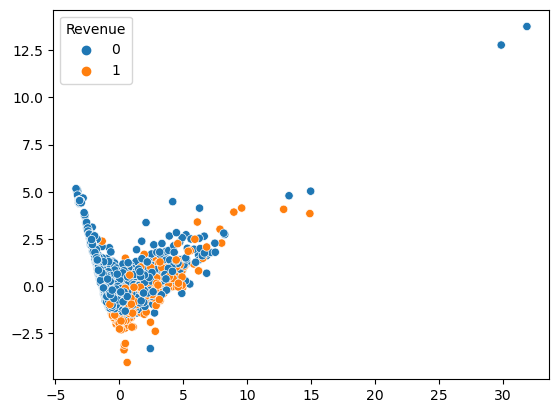

In [15]:
X0_range = (X_test_pca[:,0].min(), X_test_pca[:,0].max())
X1_range = (X_test_pca[:,1].min(), X_test_pca[:,1].max())

sns.scatterplot(x=X_test_pca[:,0], y=X_test_pca[:,1], hue=y_test, marker='o')

## Hierarchical clustering

### Agglomerative clustering

In [16]:
model_agglomerative = AgglomerativeClustering(n_clusters=n_clusters, affinity=element_distance_metric, linkage=linkage)
labels_agglomerative = model_agglomerative.fit_predict(X_test_pca)


In [17]:
metrics_agglomerative,precision_agglomerative,recall_agglomerative = get_cluster_metrics(labels_agglomerative,y_test,'Agglomerative')

precision_agglomerative
recall_agglomerative
metrics_agglomerative

,precision cluster0-class0,precision cluster0-class1,precision cluster1-class0,precision cluster1-class1
Agglomerative,0.868186,0.131814,0.770833,0.229167


,recall class0-cluster0,recall class0-cluster1,recall class1-cluster0,recall class1-cluster1
Agglomerative,0.816061,0.183939,0.69379,0.30621


,Accuracy,purity cluster 0,purity cluster 1,tot_purity,jaccard
Agglomerative,0.738806,0.868186,0.770833,0.848475,0.150844


As we can see from the results, we have a high purity (clusters are well separated) but a very low jaccard index (classes are not correctly assigned to clusters). Here we have two plots:
1. The one on the left describes only the clustering results (takes into account only the labels coming from clustering), we can see that the separation is acceptable.
2. The one on the right takes into account the labels of clustering and the labels stored in the test set. If we had a high jaccard index this plot would be very similar to the one on the left. On the contrary, here we have other two colors representing the missclassified elements.

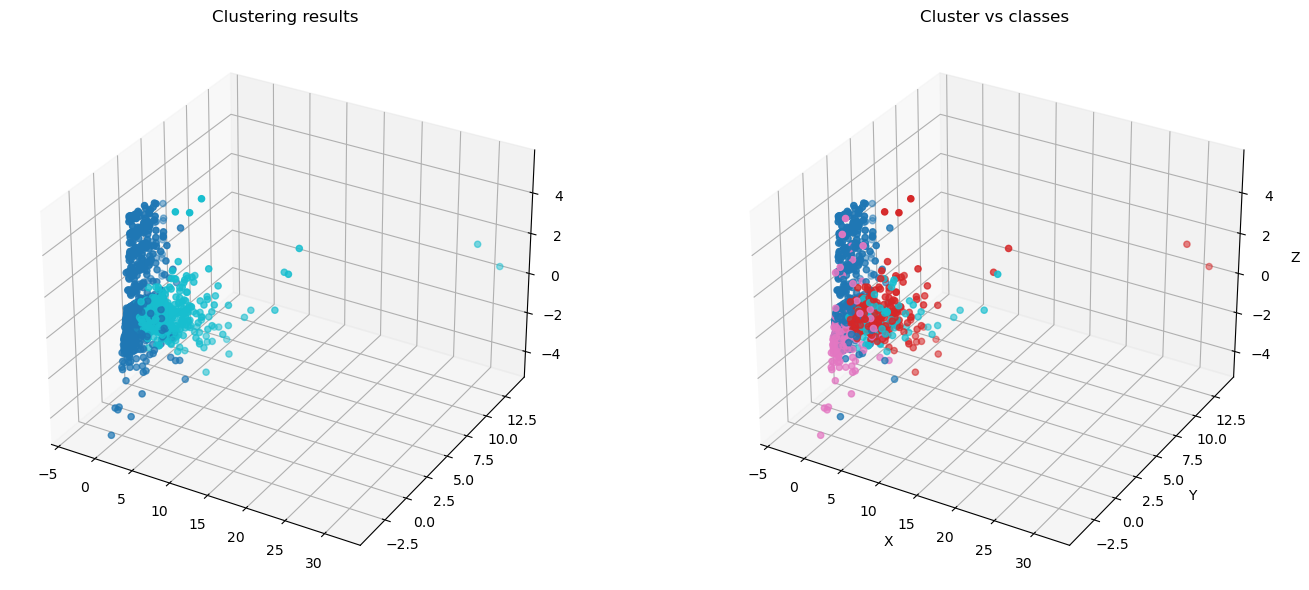

In [18]:
purity_vs_jaccard_plot(X_test_scaled.to_numpy(),labels_agglomerative,y_test)

|             | Class 0 (Revenue = FALSE)  | Class 1  (Revenue = TRUE) |
|-------------|---------:|---------:|
| Cluster 0   | Blue     | Pink      |
| Cluster 1   | Red      | Light blue      | 

## K-means

In [19]:
model_kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0)             
labels_kmeans = model_kmeans.fit_predict(X_test_pca)

In [20]:
metrics_kmeans, precision_kmeans, recall_kmeans = get_cluster_metrics(labels_kmeans,y_test,'K-means')
precision_kmeans
recall_kmeans
metrics_kmeans

,precision cluster0-class0,precision cluster0-class1,precision cluster1-class0,precision cluster1-class1
K-means,0.870584,0.129416,0.728033,0.271967


,recall class0-cluster0,recall class0-cluster1,recall class1-cluster0,recall class1-cluster1
K-means,0.866922,0.133078,0.721627,0.278373


,Accuracy,purity cluster 0,purity cluster 1,tot_purity,jaccard
K-means,0.777742,0.870584,0.728033,0.848475,0.159509


As we saw for hierarchical clustering, we have a high purity and a low jaccard index. 

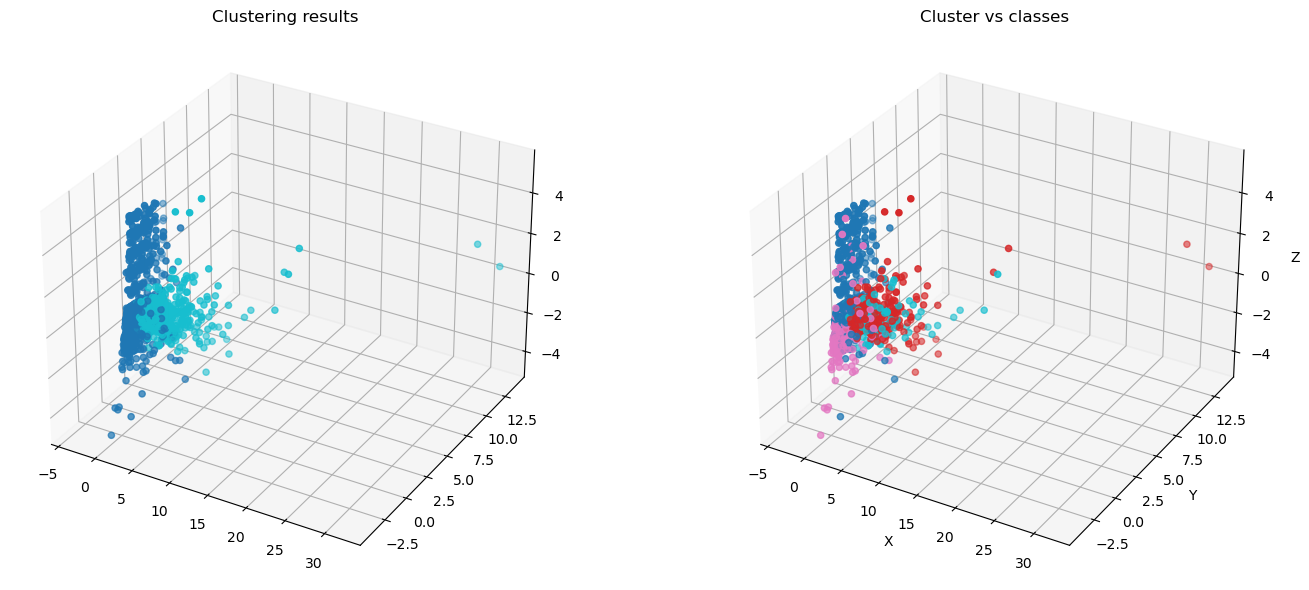

In [21]:
purity_vs_jaccard_plot(X_test_scaled.to_numpy(),labels_agglomerative,y_test)

|             | Class 0 (Revenue = FALSE)  | Class 1  (Revenue = TRUE) |
|-------------|---------:|---------:|
| Cluster 0   | Blue     | Pink      |
| Cluster 1   | Red      | Light blue      | 

## DBSCAN

To perform DBSCAN we have to choose the parameters Eps and MinPts.
- MinPts = number of desired clusters + 1 = 3
- Eps is chosen looking at the k-distance graph for k=3.

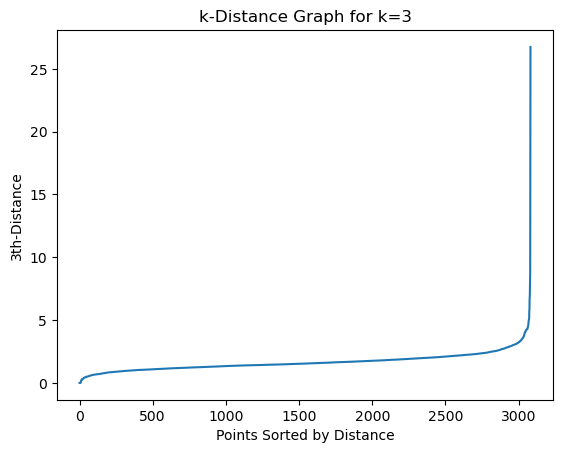

In [22]:
X=X_test_pca
k = 3
neigh = NearestNeighbors(n_neighbors=k)
distances, _ = neigh.fit(X).kneighbors(X)

# Sort the distances and plot the k-distance graph
distances = np.sort(distances[:, -1])  # Take the distance to the k-th nearest neighbor
plt.plot(np.arange(len(distances)), distances)
plt.xlabel('Points Sorted by Distance')
plt.ylabel(f'{k}th-Distance')
plt.title(f'k-Distance Graph for k={k}')
plt.show();


In [23]:
model_DBSCAN = DBSCAN(eps=4.1, min_samples=3)
labels_DBSCAN = model_DBSCAN.fit_predict(X_test_pca)

array([-1,  0,  1], dtype=int64)

In [24]:
metrics_DBSCAN,precision_DBSCAN,recall_DBSCAN = get_cluster_metrics(labels_DBSCAN[labels_DBSCAN!=-1],y_test[labels_DBSCAN!=-1],'DBSCAN')
precision_DBSCAN
recall_DBSCAN
metrics_DBSCAN

,precision cluster0-class0,precision cluster0-class1,precision cluster1-class0,precision cluster1-class1
DBSCAN,0.849656,0.150344,0.666667,0.333333


,recall class0-cluster0,recall class0-cluster1,recall class1-cluster0,recall class1-cluster1
DBSCAN,0.99923,0.00077,0.997826,0.002174


,Accuracy,purity cluster 0,purity cluster 1,tot_purity,jaccard
DBSCAN,0.849149,0.849656,0.666667,0.849476,0.002165


As we saw for hierarchical clustering and k-means, we have a high purity and a low jaccard index. 

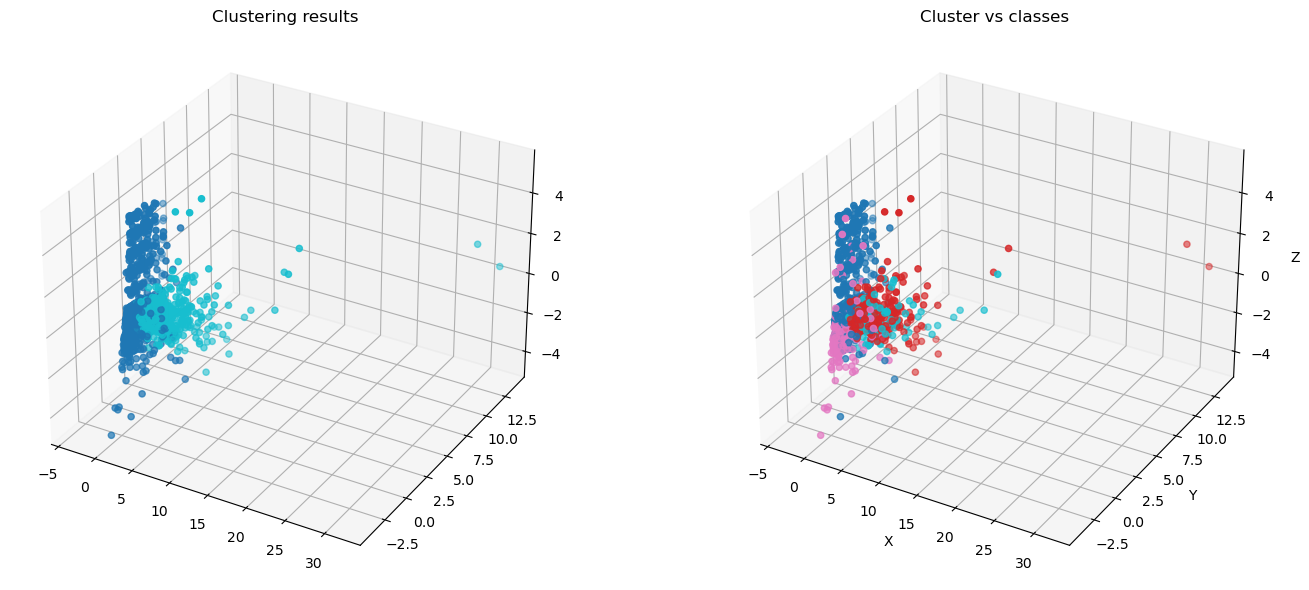

In [25]:
purity_vs_jaccard_plot(X_test_scaled.to_numpy(),labels_agglomerative,y_test)

|             | Class 0 (Revenue = FALSE)  | Class 1  (Revenue = TRUE) |
|-------------|---------:|---------:|
| Cluster 0   | Blue     | Pink      |
| Cluster 1   | Red      | Light blue      | 

## Comparison between the algorithms

In [26]:
metrics_df = pd.DataFrame()
metrics_df = pd.concat([metrics_agglomerative,metrics_kmeans,metrics_DBSCAN],axis=0)
metrics_df

,Accuracy,purity cluster 0,purity cluster 1,tot_purity,jaccard
Agglomerative,0.738806,0.868186,0.770833,0.848475,0.150844
K-means,0.777742,0.870584,0.728033,0.848475,0.159509
DBSCAN,0.849149,0.849656,0.666667,0.849476,0.002165


In [27]:
precision_df = pd.DataFrame()
precision_df = pd.concat([precision_agglomerative,precision_kmeans,precision_DBSCAN],axis=0)
precision_df

,precision cluster0-class0,precision cluster0-class1,precision cluster1-class0,precision cluster1-class1
Agglomerative,0.868186,0.131814,0.770833,0.229167
K-means,0.870584,0.129416,0.728033,0.271967
DBSCAN,0.849656,0.150344,0.666667,0.333333


In [28]:
recall_df = pd.DataFrame()
recall_df = pd.concat([recall_agglomerative,recall_kmeans,recall_DBSCAN],axis=0)
recall_df

,recall class0-cluster0,recall class0-cluster1,recall class1-cluster0,recall class1-cluster1
Agglomerative,0.816061,0.183939,0.693790,0.306210
K-means,0.866922,0.133078,0.721627,0.278373
DBSCAN,0.999230,0.000770,0.997826,0.002174


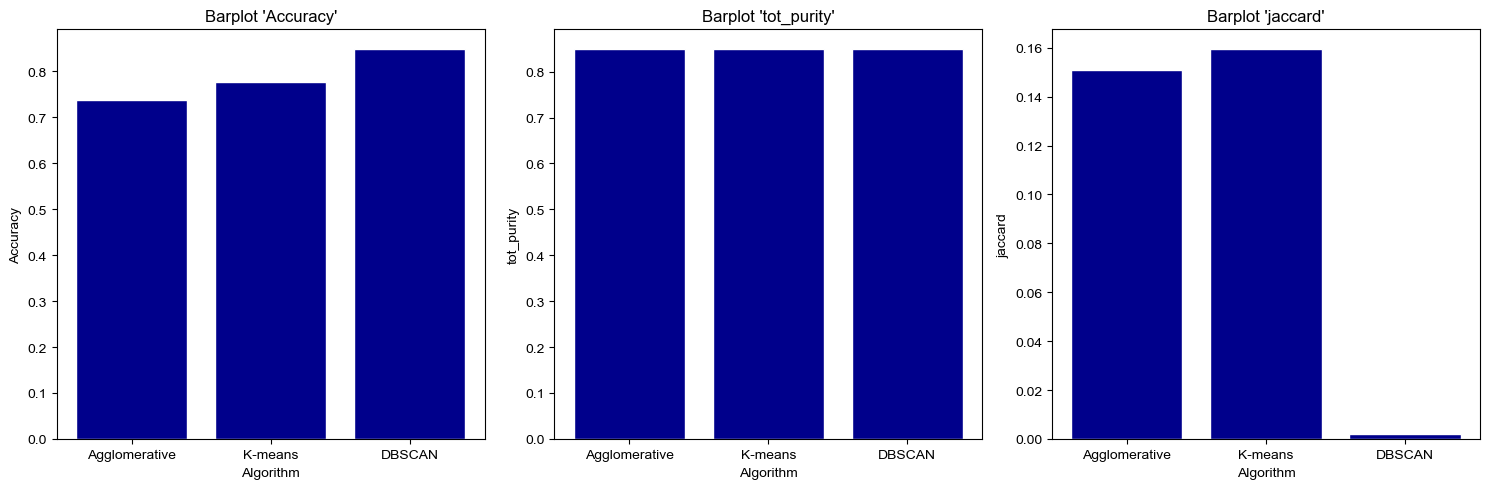

In [29]:
columns = ['Accuracy', 'tot_purity', 'jaccard']

num_cols = len(columns)
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15, 5))

sns.set_style('whitegrid')
palette = 'Set2'

for i, col in enumerate(columns):
    values = metrics_df.loc[:,col]
    axes[i].bar(metrics_df.index, values, color="darkblue")
    axes[i].set_title(f"Barplot '{col}'")
    axes[i].set_xlabel('Algorithm')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show();


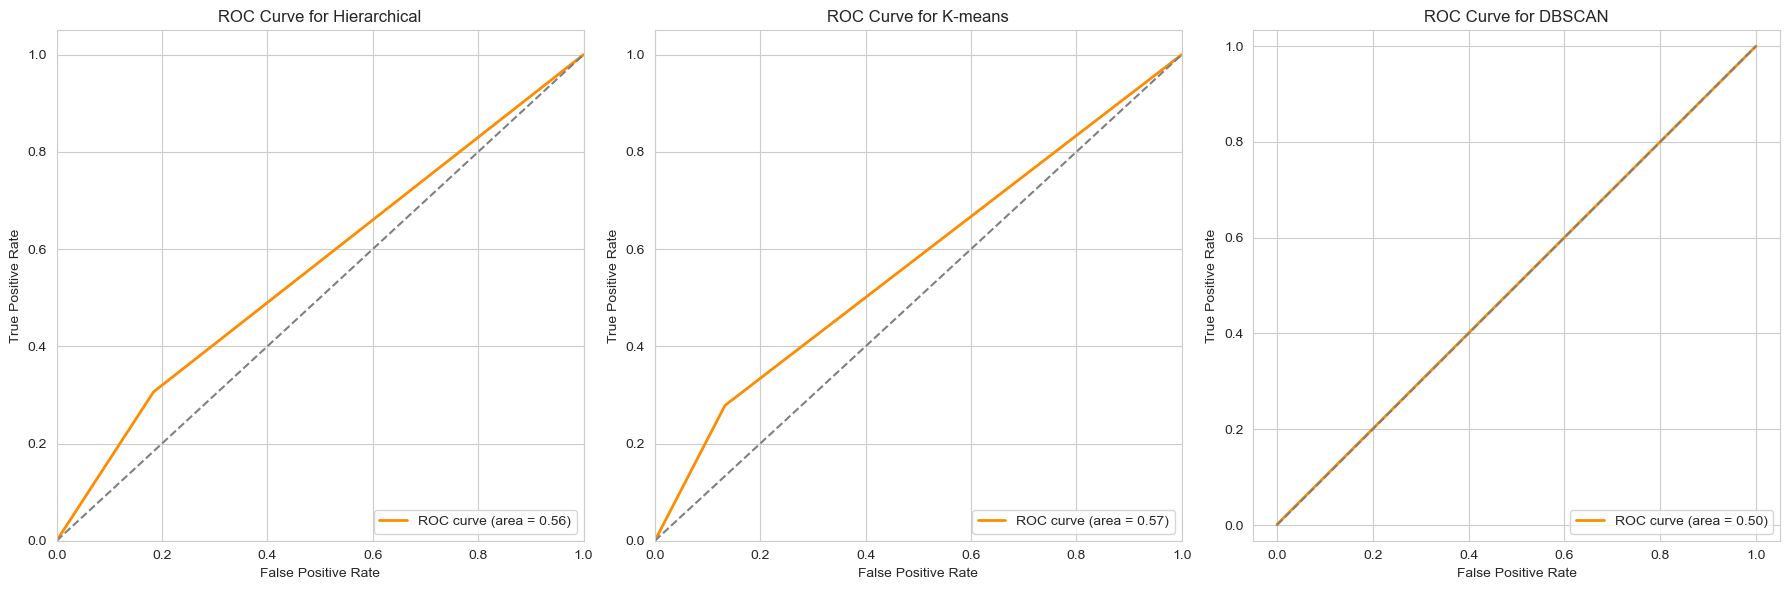

In [35]:
plt.figure(figsize=(18, 6))
ax1 = plt.subplot(1, 3, 1)
plot_roc_curve_clustering(y_test.to_numpy(), labels_agglomerative, ax1,'Hierarchical')

ax2 = plt.subplot(1, 3, 2)
plot_roc_curve_clustering(y_test.to_numpy(), labels_kmeans, ax2,'K-means')

ax3 = plt.subplot(1, 3, 3)
plot_roc_curve_clustering(y_test.to_numpy(), labels_DBSCAN, ax3,'DBSCAN')

plt.axis('equal')
plt.tight_layout()
plt.show();

As we can see the DBSCAN algorithm doesn't perform well (it's equivalent to a random classifier). As we expected looking at the jaccard index, also hierarchical clustering and k-means perform poorly.
In the end, we choose k-means as the best algorithm because it has the highest AUC.